# 5-1, Dataset和DataLoader

Pytorch通常使用Dataset和DataLoader这两个工具类来构建数据管道。

Dataset定义了数据集的内容，它相当于一个类似列表的数据结构，具有确定的长度，能够用索引获取数据集中的元素。

而DataLoader定义了按batch加载数据集的方法，它是一个实现了`__iter__`方法的可迭代对象，每次迭代输出一个batch的数据。

DataLoader能够控制batch的大小，batch中元素的采样方法，以及将batch结果整理成模型所需输入形式的方法，并且能够使用多进程读取数据。

在绝大部分情况下，用户只需实现Dataset的`__len__`方法和`__getitem__`方法，就可以轻松构建自己的数据集，并用默认数据管道进行加载。




In [1]:
import torch 
import torchvision

print("torch.__version__="+torch.__version__) 
print("torchvision.__version__="+torchvision.__version__) 


torch.__version__=2.4.0
torchvision.__version__=0.19.0


<br>

<font color="red">
 
公众号 **算法美食屋** 回复关键词：**pytorch**， 获取本项目源码和所用数据集百度云盘下载链接。
    
</font> 


### 一，深入理解Dataset和DataLoader原理

**1，获取一个batch数据的步骤**

让我们考虑一下从一个数据集中获取一个batch的数据需要哪些步骤。

(假定数据集的特征和标签分别表示为张量`X`和`Y`，数据集可以表示为`(X,Y)`, 假定batch大小为`m`)

1，首先我们要确定数据集的长度`n`。

结果类似：`n = 1000`。

2，然后我们从`0`到`n-1`的范围中抽样出`m`个数(batch大小)。

假定`m=4`, 拿到的结果是一个列表，类似：`indices = [1,4,8,9]`

3，接着我们从数据集中去取这`m`个数对应下标的元素。

拿到的结果是一个元组列表，类似：`samples = [(X[1],Y[1]),(X[4],Y[4]),(X[8],Y[8]),(X[9],Y[9])]`

4，最后我们将结果整理成两个张量作为输出。

拿到的结果是两个张量，类似`batch = (features,labels) `， 

其中 `features = torch.stack([X[1],X[4],X[8],X[9]])`

`labels = torch.stack([Y[1],Y[4],Y[8],Y[9]])`


**2，Dataset和DataLoader的功能分工**

上述第1个步骤确定数据集的长度是由 Dataset的`__len__` 方法实现的。

第2个步骤从`0`到`n-1`的范围中抽样出`m`个数的方法是由 DataLoader的 `sampler`和 `batch_sampler`参数指定的。

`sampler`参数指定单个元素抽样方法，一般无需用户设置，程序默认在DataLoader的参数`shuffle=True`时采用随机抽样，`shuffle=False`时采用顺序抽样。

`batch_sampler`参数将多个抽样的元素整理成一个列表，一般无需用户设置，默认方法在DataLoader的参数`drop_last=True`时会丢弃数据集最后一个长度不能被batch大小整除的批次，在`drop_last=False`时保留最后一个批次。

第3个步骤的核心逻辑根据下标取数据集中的元素 是由 Dataset的 `__getitem__`方法实现的。

第4个步骤的逻辑由DataLoader的参数`collate_fn`指定。一般情况下也无需用户设置。


Dataset和DataLoader的一般使用方式如下：

In [2]:
import torch 
from torch.utils.data import TensorDataset,Dataset,DataLoader
from torch.utils.data import RandomSampler,BatchSampler 


ds = TensorDataset(torch.randn(1000,3),
                   torch.randint(low=0,high=2,size=(1000,)).float())
dl = DataLoader(ds,batch_size=4,drop_last = False)
features,labels = next(iter(dl))
print("features = ",features )
print("labels = ",labels )  



features =  tensor([[ 0.6751, -0.3811,  0.5684],
        [-0.3770,  0.8856,  0.0909],
        [ 0.8428, -1.8420,  1.0782],
        [-0.3983, -0.1792, -0.4158]])
labels =  tensor([0., 0., 0., 0.])


```
features =  tensor([[-0.3979,  0.4728, -0.9796],
        [-1.0995,  0.7045,  0.7593],
        [-0.9703, -0.6259, -0.2886],
        [-1.1529, -0.7042, -0.8151]])
labels =  tensor([1., 0., 0., 0.])
```

将DataLoader内部调用方式步骤拆解如下：

In [3]:
# step1: 确定数据集长度 (Dataset的 __len__ 方法实现)
ds = TensorDataset(torch.randn(1000,3),
                   torch.randint(low=0,high=2,size=(1000,)).float())
print("n = ", len(ds)) # len(ds)等价于 ds.__len__()

# step2: 确定抽样indices (DataLoader中的 Sampler和BatchSampler实现)
sampler = RandomSampler(data_source = ds)
batch_sampler = BatchSampler(sampler = sampler, 
                             batch_size = 4, drop_last = False)
for idxs in batch_sampler:
    indices = idxs
    break 
print("indices = ",indices)

# step3: 取出一批样本batch (Dataset的 __getitem__ 方法实现)
batch = [ds[i] for i in  indices]  #  ds[i] 等价于 ds.__getitem__(i)
print("batch = ", batch)

# step4: 整理成features和labels (DataLoader 的 collate_fn 方法实现)
def collate_fn(batch):
    features = torch.stack([sample[0] for sample in batch])
    labels = torch.stack([sample[1] for sample in batch])
    return features,labels 

features,labels = collate_fn(batch)
print("features = ",features)
print("labels = ",labels)


n =  1000
indices =  [814, 952, 215, 885]
batch =  [(tensor([ 1.4562,  1.3365, -1.3643]), tensor(0.)), (tensor([ 0.6681, -0.0161,  0.1268]), tensor(1.)), (tensor([-1.0665, -0.2159, -0.0633]), tensor(0.)), (tensor([ 0.6040,  0.7050, -0.7451]), tensor(0.))]
features =  tensor([[ 1.4562,  1.3365, -1.3643],
        [ 0.6681, -0.0161,  0.1268],
        [-1.0665, -0.2159, -0.0633],
        [ 0.6040,  0.7050, -0.7451]])
labels =  tensor([0., 1., 0., 0.])


**3，Dataset和DataLoader的核心源码**

以下是 Dataset和 DataLoader的核心源码，省略了为了提升性能而引入的诸如多进程读取数据相关的代码。


In [4]:
import torch 
class Dataset(object):
    def __init__(self):
        pass
    
    def __len__(self):
        raise NotImplementedError
        
    def __getitem__(self,index):
        raise NotImplementedError
        

class DataLoader(object):
    def __init__(self,dataset,batch_size,collate_fn = None,shuffle = True,drop_last = False):
        self.dataset = dataset
        self.collate_fn = collate_fn
        self.sampler =torch.utils.data.RandomSampler if shuffle else \
           torch.utils.data.SequentialSampler
        self.batch_sampler = torch.utils.data.BatchSampler
        self.sample_iter = self.batch_sampler(
            self.sampler(self.dataset),
            batch_size = batch_size,drop_last = drop_last)
        self.collate_fn = collate_fn if collate_fn is not None else \
            torch.utils.data._utils.collate.default_collate
        
    def __next__(self):
        indices = next(iter(self.sample_iter))
        batch = self.collate_fn([self.dataset[i] for i in indices])
        return batch
    
    def __iter__(self):
        return self
    

我们来测试一番

In [5]:
class ToyDataset(Dataset):
    def __init__(self,X,Y):
        self.X = X
        self.Y = Y 
    def __len__(self):
        return len(self.X)
    def __getitem__(self,index):
        return self.X[index],self.Y[index]
    
X,Y = torch.randn(1000,3),torch.randint(low=0,high=2,size=(1000,)).float()
ds = ToyDataset(X,Y)

dl = DataLoader(ds,batch_size=4,drop_last = False)
features,labels = next(iter(dl))
print("features = ",features )
print("labels = ",labels )  

features =  tensor([[ 0.2655,  0.6133,  1.1722],
        [-0.9634, -1.5688, -0.2817],
        [ 1.9041,  0.5612, -1.2540],
        [-1.2843,  1.0088,  0.6784]])
labels =  tensor([1., 0., 1., 0.])


```
features =  tensor([[ 0.6718, -0.5819,  0.9362],
        [-0.4208, -0.1517,  0.3838],
        [ 2.1848, -1.2617,  0.7580],
        [ 0.1418, -1.6424,  0.3673]])
labels =  tensor([0., 1., 1., 0.])
```

完美, 和预期一致!

### 二，使用Dataset创建数据集

Dataset创建数据集常用的方法有：

* 使用 torch.utils.data.TensorDataset 根据Tensor创建数据集(numpy的array，Pandas的DataFrame需要先转换成Tensor)。

* 使用 torchvision.datasets.ImageFolder 根据图片目录创建图片数据集。

* 继承 torch.utils.data.Dataset 创建自定义数据集。


此外，还可以通过

* torch.utils.data.random_split 将一个数据集分割成多份，常用于分割训练集，验证集和测试集。

* 调用Dataset的加法运算符(`+`)将多个数据集合并成一个数据集。


**1，根据Tensor创建数据集**

In [6]:
import numpy as np 
import torch 
from torch.utils.data import TensorDataset,Dataset,DataLoader,random_split 


In [7]:
# 根据Tensor创建数据集

from sklearn import datasets 
iris = datasets.load_iris()
ds_iris = TensorDataset(torch.tensor(iris.data),torch.tensor(iris.target))

# 分割成训练集和预测集
n_train = int(len(ds_iris)*0.8)
n_val = len(ds_iris) - n_train
ds_train,ds_val = random_split(ds_iris,[n_train,n_val])

print(type(ds_iris))
print(type(ds_train))


<class 'torch.utils.data.dataset.TensorDataset'>
<class 'torch.utils.data.dataset.Subset'>


In [8]:
# 使用DataLoader加载数据集
dl_train,dl_val = DataLoader(ds_train,batch_size = 8),DataLoader(ds_val,batch_size = 8)

for features,labels in dl_train:
    print(features,labels)
    break

tensor([[5.1000, 3.8000, 1.5000, 0.3000],
        [5.4000, 3.0000, 4.5000, 1.5000],
        [5.9000, 3.0000, 5.1000, 1.8000],
        [6.5000, 3.0000, 5.5000, 1.8000],
        [6.7000, 3.1000, 4.4000, 1.4000],
        [6.4000, 3.1000, 5.5000, 1.8000],
        [5.1000, 3.3000, 1.7000, 0.5000],
        [6.1000, 2.6000, 5.6000, 1.4000]], dtype=torch.float64) tensor([0, 1, 2, 2, 1, 2, 0, 2])


In [9]:
# 演示加法运算符（`+`）的合并作用

ds_data = ds_train + ds_val

print('len(ds_train) = ',len(ds_train))
print('len(ds_valid) = ',len(ds_val))
print('len(ds_train+ds_valid) = ',len(ds_data))

print(type(ds_data))


len(ds_train) =  120
len(ds_valid) =  30
len(ds_train+ds_valid) =  150
<class 'torch.utils.data.dataset.ConcatDataset'>


**2，根据图片目录创建图片数据集**

In [10]:
import numpy as np 
import torch 
from torch.utils.data import DataLoader
from torchvision import transforms,datasets 


In [ ]:
#演示一些常用的图片增强操作

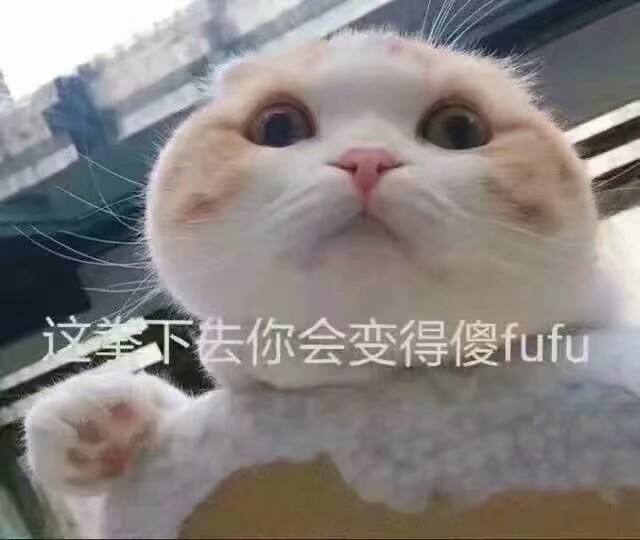

In [11]:
from PIL import Image
img = Image.open('./data/cat.jpeg')
img

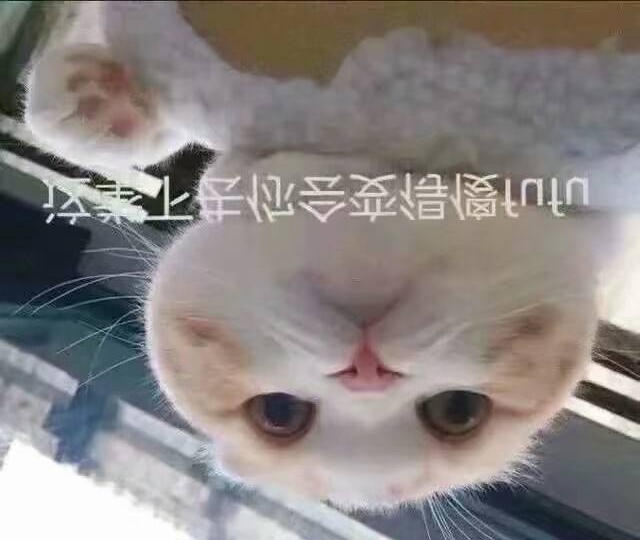

In [12]:
# 随机数值翻转
transforms.RandomVerticalFlip()(img)

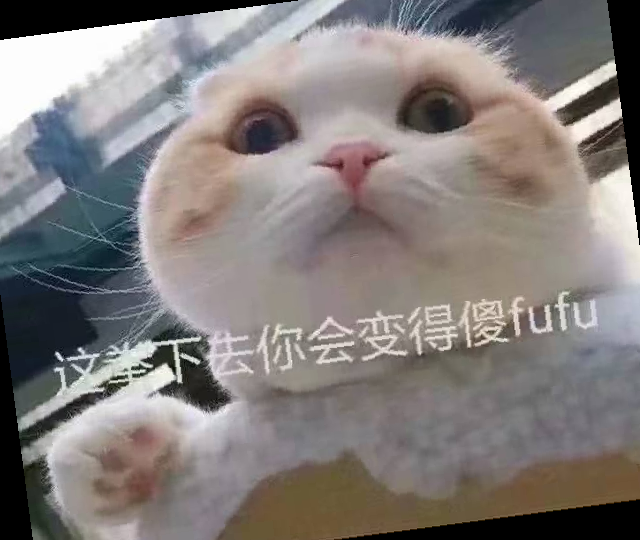

In [13]:
#随机旋转
transforms.RandomRotation(45)(img)

In [14]:
# 定义图片增强操作

transform_train = transforms.Compose([
   transforms.RandomHorizontalFlip(), #随机水平翻转
   transforms.RandomVerticalFlip(), #随机垂直翻转
   transforms.RandomRotation(45),  #随机在45度角度内旋转
   transforms.ToTensor() #转换成张量
  ]
) 

transform_valid = transforms.Compose([
    transforms.ToTensor()
  ]
)


In [15]:
# 根据图片目录创建数据集

def transform_label(x):
    return torch.tensor([x]).float()

ds_train = datasets.ImageFolder("./eat_pytorch_datasets/cifar2/train/",
            transform = transform_train,target_transform= transform_label)
ds_val = datasets.ImageFolder("./eat_pytorch_datasets/cifar2/test/",
                              transform = transform_valid,
                              target_transform= transform_label)


print(ds_train.class_to_idx)

# 使用DataLoader加载数据集

dl_train = DataLoader(ds_train,batch_size = 50,shuffle = True)
dl_val = DataLoader(ds_val,batch_size = 50,shuffle = True)


for features,labels in dl_train:
    print(features.shape)
    print(labels.shape)
    break
    

{'0_airplane': 0, '1_automobile': 1}
torch.Size([50, 3, 32, 32])
torch.Size([50, 1])


**3，创建自定义数据集**

下面我们通过另外一种方式，即继承 torch.utils.data.Dataset 创建自定义数据集的方式来对 cifar2构建 数据管道。


In [16]:
from pathlib import Path 
from PIL import Image 

class Cifar2Dataset(Dataset):
    def __init__(self,imgs_dir,img_transform):
        self.files = list(Path(imgs_dir).rglob("*.jpg"))
        self.transform = img_transform
        
    def __len__(self,):
        return len(self.files)
    
    def __getitem__(self,i):
        file_i = str(self.files[i])
        img = Image.open(file_i)
        tensor = self.transform(img)
        label = torch.tensor([1.0]) if  "1_automobile" in file_i else torch.tensor([0.0])
        return tensor,label 
    
    
train_dir = "./eat_pytorch_datasets/cifar2/train/"
test_dir = "./eat_pytorch_datasets/cifar2/test/"

            

In [17]:
# 定义图片增强
transform_train = transforms.Compose([
   transforms.RandomHorizontalFlip(), #随机水平翻转
   transforms.RandomVerticalFlip(), #随机垂直翻转
   transforms.RandomRotation(45),  #随机在45度角度内旋转
   transforms.ToTensor() #转换成张量
  ]
) 

transform_val = transforms.Compose([
    transforms.ToTensor()
  ]
)

In [18]:
ds_train = Cifar2Dataset(train_dir,transform_train)
ds_val = Cifar2Dataset(test_dir,transform_val)


dl_train = DataLoader(ds_train,batch_size = 50,shuffle = True)
dl_val = DataLoader(ds_val,batch_size = 50,shuffle = True)


for features,labels in dl_train:
    print(features.shape)
    print(labels.shape)
    break
    


torch.Size([50, 3, 32, 32])
torch.Size([50, 1])


### 三，使用DataLoader加载数据集

DataLoader能够控制batch的大小，batch中元素的采样方法，以及将batch结果整理成模型所需输入形式的方法，并且能够使用多进程读取数据。

DataLoader的函数签名如下。

```python
DataLoader(
    dataset,
    batch_size=1,
    shuffle=False,
    sampler=None,
    batch_sampler=None,
    num_workers=0,
    collate_fn=None,
    pin_memory=False,
    drop_last=False,
    timeout=0,
    worker_init_fn=None,
    multiprocessing_context=None,
)
```


一般情况下，我们仅仅会配置 dataset, batch_size, shuffle, num_workers,pin_memory, drop_last这六个参数，

有时候对于一些复杂结构的数据集，还需要自定义collate_fn函数，其他参数一般使用默认值即可。

DataLoader除了可以加载我们前面讲的 torch.utils.data.Dataset 外，还能够加载另外一种数据集 torch.utils.data.IterableDataset。

和Dataset数据集相当于一种列表结构不同，IterableDataset相当于一种迭代器结构。 它更加复杂，一般较少使用。

- dataset : 数据集
- batch_size: 批次大小
- shuffle: 是否乱序
- sampler: 样本采样函数，一般无需设置。
- batch_sampler: 批次采样函数，一般无需设置。
- num_workers: 使用多进程读取数据，设置的进程数。
- collate_fn: 整理一个批次数据的函数。
- pin_memory: 是否设置为锁业内存。默认为False，锁业内存不会使用虚拟内存(硬盘)，从锁业内存拷贝到GPU上速度会更快。
- drop_last: 是否丢弃最后一个样本数量不足batch_size批次数据。
- timeout: 加载一个数据批次的最长等待时间，一般无需设置。
- worker_init_fn: 每个worker中dataset的初始化函数，常用于 IterableDataset。一般不使用。



In [19]:
#构建输入数据管道
ds = TensorDataset(torch.arange(1,50))
dl = DataLoader(ds,
                batch_size = 10,
                shuffle= True,
                num_workers=2,
                drop_last = True)
#迭代数据
for batch, in dl:
    print(batch)

tensor([ 9,  2, 13,  5, 12, 19, 31, 17, 47, 41])
tensor([24,  8, 23, 11, 15, 35, 16,  1, 48, 33])
tensor([37, 18,  7, 43, 32, 28, 44, 38, 46, 20])
tensor([ 4, 39, 34, 21,  3, 10, 40, 42, 14, 26])


**如果本书对你有所帮助，想鼓励一下作者，记得给本项目加一颗星星star⭐️，并分享给你的朋友们喔😊!** 

如果对本书内容理解上有需要进一步和作者交流的地方，欢迎在公众号"算法美食屋"下留言。作者时间和精力有限，会酌情予以回复。

也可以在公众号后台回复关键字：**加群**，加入读者交流群和大家讨论。

![算法美食屋logo.png](https://tva1.sinaimg.cn/large/e6c9d24egy1h41m2zugguj20k00b9q46.jpg)